# Lab:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./demo_mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics: https://steinhardt.nyu.edu/marl/research/deep_learning_in_music_informatics

## Loading the PyTorch package
We begin by loading PyTorch and the other packages.  If you have not already installed the PyTorch package on your computer, you may need to do so.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch

## Audio Feature Extraction with Librosa

The key to accurate audio classification is to extract good features. In addition to `torch`, we will use the `librosa` package.  The `librosa` package in python has a rich set of audio feature extraction methods for machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  After you have installed the package, you should be able to import it as follows.

In [2]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from http://theremin.music.uiowa.edu

This website has great files for audio processing.  We will use the `requests.get` and `file.write` commands to load the file from a given URL into the working directory.

In [3]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

req = requests.get(url)
with open(fn, "wb") as file:        
    file.write(req.content) # write to file

If the above fails, you may need to install `requests` with `conda install requests`.

Next, we'll use the `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [4]:
y, sr = librosa.load(fn)

Let's play the audio file.  You should hear a soprano saxaphone playing four notes (C, C#, D, Eb).

In [5]:
# TODO: play audio file using IPython.display (recall the lab from unit 6)

import IPython.display as ipd
ipd.Audio(y, rate=sr) # load a NumPy array

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called "mel" spectrogram, which represents both frequency and power in the log domain.  This is motivated by human perceptual processing, which does something similar.  The code below displays the mel spectrogram of the audio sample.

The spectrogram clearly shows the four notes played in the audio track.  It also shows the "harmonics" of each note, which are the frequency components at integer multiples of the fundamental frequency of each note.

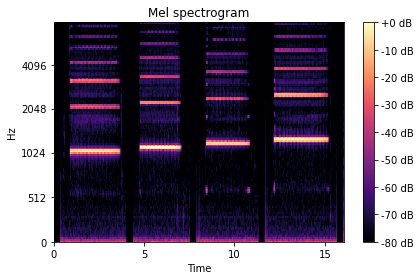

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above and, for each audio file, they segmented the track into notes and then extracted 120 MFCCs for each note.  The goal was to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say, `instrument_dataset`.  Then, load the data into numpy arrays as follows.

In [7]:
data_dir = '/Users/zhangzhangbowen/Desktop/instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

From these data files, write code that prints out:
* the number of training and test samples
* the number of features in each sample
* the number of classes (i.e., instruments to recognize)

In [8]:
# TODO
print('Num training= {0:d}'.format(Xtr.shape[0]))
print('Num test=     {0:d}'.format(Xts.shape[0]))
print('Num features= {0:d}'.format(Xtr.shape[1]))
print('Num classes=  {0:d}'.format(np.max(ytr)+1))

Num training= 66247
Num test=     14904
Num features= 120
Num classes=  10


Before continuing, we will standardize the training and test data, `Xtr` and `Xts`.  First compute the mean and std deviation of each feature in `Xtr`.  Then create a new training data set, `Xtr_scale`, by subtracting the feature means from `Xtr` and dividing by the feature std deviations.  Then create a standardized test dataset, `Xts_scale`, **using the mean and std deviation computed on the training dataset**.

In [9]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
xmean = np.mean(Xtr,axis=0)
xstd = np.std(Xtr,axis=0)
Xtr_scale = (Xtr-xmean[None,:])/xstd[None,:]
Xts_scale = (Xts-xmean[None,:])/xstd[None,:]

## Create DataLoaders

To use PyTorch, we first create a Dataloader using the `TensorDataset` and `DataLoader` commands, just as in the demos. We will use `batch_size = 100`.

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 100

# TODO Convert the numpy arrays to tensors
Xtr_torch = torch.Tensor(Xtr_scale)
ytr_torch = torch.Tensor(ytr)
Xts_torch = torch.Tensor(Xts_scale)
yts_torch = torch.Tensor(yts)

# TODO Create a training/test dataset from the tensors
# train_ds = ...
# test_ds = ...
train_ds = TensorDataset(Xtr_torch, ytr_torch)
# Create a testing Dataset from the tensors
test_ds = TensorDataset(Xts_torch, yts_torch)


# TODO Create a training/test data loader from datasets
# train_loader = ...
# test_loader = ...
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=batch_size) 

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./demo_mnist_neural.ipynb), create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation

Make sure to select the input and output dimensions correctly, and print the model summary.

In [11]:
import torch.nn as nn

nin = Xtr.shape[1]
nout = np.max(ytr)+1
nh = 256


class Net(nn.Module):
    def __init__(self,nin,nh,nout):
        super(Net,self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.Dense1 = nn.Linear(nin,nh)
        self.Dense2 = nn.Linear(nh,nout)
        
    def forward(self,x):
        x = self.sigmoid(self.Dense1(x))
        out = self.Dense2(x)
        return out

model = Net(nin=nin, nh=nh, nout=nout)

print(str(model))

Net(
  (sigmoid): Sigmoid()
  (Dense1): Linear(in_features=120, out_features=256, bias=True)
  (Dense2): Linear(in_features=256, out_features=10, bias=True)
)


## Training the Network

Next, select an optimizer (linked to the parameters of your new model) and a loss function. For the optimizer, we suggest to start with the Adam optimizer with a learning rate of 0.001.

In [12]:
import torch.optim as optim


opt = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

Train the model for 10 epochs using the scaled training data.  For **every batch**, record the training loss. 
For **every epoch**, record the training accuracy, the test loss, and the test accuracy.  Use the variable names defined below.  The code should be similar to that in the MNIST demo.

In [13]:
# TODO Train model for 10 epochs

a_tr_loss = []
a_tr_accuracy = []
a_ts_loss = []
a_ts_accuracy = []

num_epoch = 10

for epoch in range(num_epoch):
    model.train() # put model in training mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    # iterate over training set
    for train_iter, data in enumerate(train_loader):
        x_batch,y_batch = data
        y_batch = y_batch.type(torch.long)
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        a_tr_loss.append(loss.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        # Do hard classification: index of largest score
        _, predicted = torch.max(out.data, 1)
        # Compute number of decision errors
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_accuracy.append( 100*correct/total )
    
    model.eval() # put model in evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = labels.type(torch.long)
            outputs = model(images)
            loss = criterion(outputs,labels)
            a_ts_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    a_ts_accuracy.append( 100*correct/total )
    
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Accuracy: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
          +'Test Accuracy: {0:.2f}'.format(a_ts_accuracy[epoch]))
        

Epoch:  1   Train Loss: 2.334   Train Accuracy: 88.25    Test Loss: 0.126   Test Accuracy: 94.06
Epoch:  2   Train Loss: 2.226   Train Accuracy: 97.55    Test Loss: 0.192   Test Accuracy: 97.27
Epoch:  3   Train Loss: 2.082   Train Accuracy: 98.56    Test Loss: 0.143   Test Accuracy: 98.26
Epoch:  4   Train Loss: 2.016   Train Accuracy: 98.99    Test Loss: 0.185   Test Accuracy: 98.88
Epoch:  5   Train Loss: 1.977   Train Accuracy: 99.23    Test Loss: 0.180   Test Accuracy: 99.09
Epoch:  6   Train Loss: 1.910   Train Accuracy: 99.39    Test Loss: 0.111   Test Accuracy: 99.21
Epoch:  7   Train Loss: 1.936   Train Accuracy: 99.47    Test Loss: 0.126   Test Accuracy: 99.23
Epoch:  8   Train Loss: 1.778   Train Accuracy: 99.59    Test Loss: 0.052   Test Accuracy: 99.17
Epoch:  9   Train Loss: 1.888   Train Accuracy: 99.64    Test Loss: 0.034   Test Accuracy: 99.15
Epoch: 10   Train Loss: 1.818   Train Accuracy: 99.69    Test Loss: 0.136   Test Accuracy: 99.16


Plot the test accuracy versus epoch, as saved in `a_ts_accuracy`. You should see a final accuracy $> 99\%$.

Text(0, 0.5, 'Test accuracy')

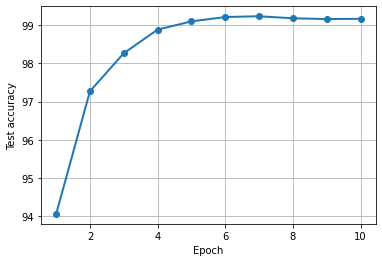

In [14]:
# TODO
# plt.plot(...)
# ...
nepochs = len(a_ts_accuracy)
plt.plot(np.arange(1,nepochs+1), a_ts_accuracy, 'o-', linewidth=2)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')

Plot the loss **versus batch**, as saved in `a_tr_loss`, using `semilogy`.  But label the x-axis in units of epochs.  Note that the relation between the epoch and batch index `i` is `epoch = i*batch_size/ntr`, given `batch_size` and a total of `ntr` training samples.

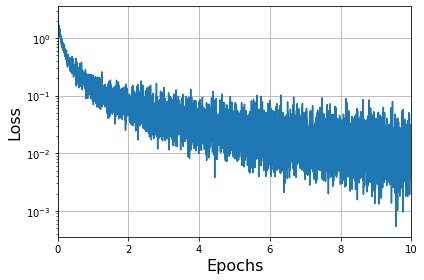

In [15]:
nsteps = len(a_tr_loss)
ntr = Xtr.shape[0]
epochs = np.arange(1,nsteps+1)*batch_size/ntr
plt.semilogy(epochs, a_tr_loss)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
plt.xlim([0,np.max(epochs)])
plt.tight_layout()

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Re-run the above code inside a for loop that trys the 3 learning rates given in the vector `rates`.  For each learning rate:
* instantiate the model (which resets the learned parameters),
* construct the optimizer (i.e., Adam with the appropriate learning rate),
* train the model,
* record the loss versus batch and accuracy versus epoch, as before.

In [16]:
rates = [0.01,0.001,0.0001]
loss_hist = []
val_acc_hist = []

# TODO
for lr in rates:
    model = Net(nin=nin, nh=nh, nout=nout)

    opt = optim.Adam(model.parameters(), lr=lr)     
        
    num_epoch = 10

    a_tr_loss = []
    a_tr_accuracy = []
    a_ts_loss = []
    a_ts_accuracy = []

    for epoch in range(num_epoch):
        model.train() # put model in training mode
        correct = 0 # initialize error counter
        total = 0 # initialize total counter
        # iterate over training set
        for train_iter, data in enumerate(train_loader):
            x_batch,y_batch = data
            y_batch = y_batch.type(torch.long)
            out = model(x_batch)
            # Compute Loss
            loss = criterion(out,y_batch)
            a_tr_loss.append(loss.item())
            # Compute gradients using back propagation
            opt.zero_grad()
            loss.backward()
            # Take an optimization 'step'
            opt.step()
            # Do hard classification: index of largest score
            _, predicted = torch.max(out.data, 1)
            # Compute number of decision errors
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        a_tr_accuracy.append( 100*correct/total )

        model.eval() # put model in evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                labels = labels.type(torch.long)
                outputs = model(images)
                loss = criterion(outputs,labels)
                a_ts_loss.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        a_ts_accuracy.append( 100*correct/total )

        # Print details every print_mod epoch
        print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
              +'Train Accuracy: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
              +'Test Accuracy: {0:.2f}'.format(a_ts_accuracy[epoch]))
    loss_hist.append(a_tr_loss)
    val_acc_hist.append(a_ts_accuracy)
    
    # Print the final accuracy
    print("lr=%12.4e test accuracy=%f" % (lr, a_ts_accuracy[-1]))

Epoch:  1   Train Loss: 2.453   Train Accuracy: 96.56    Test Loss: 0.006   Test Accuracy: 98.71
Epoch:  2   Train Loss: 1.996   Train Accuracy: 99.03    Test Loss: 0.043   Test Accuracy: 98.38
Epoch:  3   Train Loss: 1.879   Train Accuracy: 99.35    Test Loss: 0.038   Test Accuracy: 98.12
Epoch:  4   Train Loss: 1.658   Train Accuracy: 99.44    Test Loss: 0.033   Test Accuracy: 97.01
Epoch:  5   Train Loss: 1.263   Train Accuracy: 99.54    Test Loss: 0.024   Test Accuracy: 98.91
Epoch:  6   Train Loss: 1.174   Train Accuracy: 99.50    Test Loss: 0.012   Test Accuracy: 98.54
Epoch:  7   Train Loss: 0.984   Train Accuracy: 99.66    Test Loss: 0.011   Test Accuracy: 98.75
Epoch:  8   Train Loss: 1.208   Train Accuracy: 99.55    Test Loss: 0.002   Test Accuracy: 98.64
Epoch:  9   Train Loss: 0.920   Train Accuracy: 99.66    Test Loss: 0.001   Test Accuracy: 98.94
Epoch: 10   Train Loss: 0.860   Train Accuracy: 99.71    Test Loss: 0.017   Test Accuracy: 98.69
lr=  1.0000e-02 test accuracy=

Plot the loss vs. batch index (again labeling the x-axis in units of epochs) for all three learning rates on one graph.  You should see that, at a lower learning rate, the loss is more stable but converges more slowly.

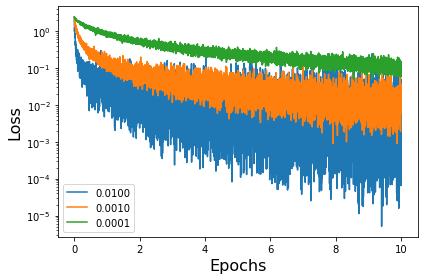

In [17]:
# TODO
ntest = len(loss_hist)
ntr = Xtr.shape[0]
batch_size=100
for it, loss in enumerate(loss_hist):
    nsteps = len(loss)
    epochs = np.arange(nsteps)*batch_size/ntr

    plt.semilogy(epochs, loss)

    rate_str = ['{0:5.4f}'.format(lr) for lr in rates]

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(rate_str,loc='lower left')
plt.tight_layout()